In [187]:
%config IPCompleter.use_jedi = False
import numpyro

numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS

# import pyro.infer
# import pyro.optim
# import pyro.distributions as dist
# from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools
from dfply import *
import glob

%run -i 'model_helpers.py'

# glob.glob('data*.csv') - returns List[str]
# pd.read_csv(f) - returns pd.DataFrame()
# for f in glob.glob() - returns a List[DataFrames]
# pd.concat() - returns one pd.DataFrame()
df = pd.concat([pd.read_csv(f) for f in glob.glob('osfstorage-archive/Experiment 2/*.csv')], ignore_index = True)

fix_id_dict = dict()
original_ids = list(np.unique(df.ID))

for i in range(0, len(original_ids)):
    fix_id_dict[original_ids[i]] = i

       

df = (df >> 
     filter_by(~X.querydetail.str.contains("(warm|snowy)")) >>
      mutate(estimate = X.estimate/100.) >>
      group_by(X.ID, X.querytype, X.querydetail) >>
      summarize(estimate = np.mean(X.estimate)) >>
      mutate(coldrainy = X.querydetail.str.contains("(cold|rainy)").astype("int")) >>
      mutate(estimate = X.estimate.replace({0:.01, 1:.99})) >>
      mutate(conjdisj_trial = X.querytype.apply(is_conjdisj)) >>
      mutate(ID = X.ID.apply(lambda x: fix_id_dict[x]))
     )

df

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,querydetail,querytype,ID,estimate,coldrainy,conjdisj_trial
0,cold,A,0,0.676667,1,0
1,windy,A,0,0.733333,0,0
2,cold and rainy,AandB,0,0.760000,1,1
3,windy and cloudy,AandB,0,0.773333,0,1
4,cold and not rainy,AandnotB,0,0.753333,1,1
...,...,...,...,...,...,...
3355,not rainy,notB,83,0.246667,1,0
3356,not cloudy given windy,notBgA,83,0.416667,0,0
3357,not rainy given cold,notBgA,83,0.500000,1,0
3358,not cloudy given not windy,notBgnotA,83,0.326667,0,0


In [191]:


df_test = df
# df_test = df >> filter_by(X.conjdisj_trial==0)
# df_test = df >> filter_by(X.coldrainy==1)

trial_list = list(df_test.querytype)
X_num = jnp.stack([num_vecs[trial] for trial in trial_list])
X_denom = jnp.stack([denom_vecs[trial] for trial in trial_list])

X_data = {
    "trial": trial_list,
    "X_num": X_num,
    "X_denom": X_denom,
    "subj": jnp.array(list(df_test.ID)),
    "conjdisj_trial": jnp.array(list(df_test.conjdisj_trial)),
    "cond": jnp.array(list(df_test.coldrainy)).astype("int32")
#     "block": jnp.array(list(df_test.block))
}

y_data = jnp.array(df_test.estimate.to_numpy())
# df_test.ID.unique()
df_test.head()

,querydetail,querytype,ID,estimate,coldrainy,conjdisj_trial
0,cold,A,0,0.676667,1,0
1,windy,A,0,0.733333,0,0
2,cold and rainy,AandB,0,0.760000,1,1
3,windy and cloudy,AandB,0,0.773333,0,1
4,cold and not rainy,AandnotB,0,0.753333,1,1


In [234]:
def bayesian_sampler_complex(data, y=None):

    n_Ps = len(np.unique(data["subj"]))
    n_conds = len(np.unique(data["cond"]))
    trial = data["trial"]
    subj = data["subj"]
    cond = data["cond"]
    
    not_conjdisj = abs(1-data["conjdisj_trial"])

    # population level parameters/priors
    sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
#     k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # need a beta, and N's per person
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
        N_deltas = numpyro.sample("N_delta", dist.HalfCauchy(10))
        N_primes = numpyro.sample("N_prime", dist.HalfCauchy(10))
        
        # need a theta per person-query
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    N = 1 + N_primes[subj] + N_deltas[subj] * not_conjdisj # they required N be at least 1, no pooling for now
    
    beta = betas[subj]
    theta_ind = ((subj*2)+cond)
    theta = thetas[theta_ind,:]
        
    numerator = jnp.sum(theta*data["X_num"], axis=-1)
    denom = jnp.sum(theta*data["X_denom"], axis=-1)
    pi = jnp.divide(numerator, denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)

    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Normal(p_bs, sigma), obs = y) # wrong but replicates paper
#         yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [235]:

from jax import random
from numpyro.infer import MCMC, NUTS

# numpyro.enable_validation()
nuts_kernel = NUTS(bayesian_sampler_complex, target_accept_prob=.80)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2_000, num_chains=2)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [244]:
# mcmc.print_summary()

In [237]:
import arviz as az
from numpyro.infer import Predictive
from jax.random import PRNGKey

posterior_samples = mcmc.get_samples()
# posterior = Predictive(bayesian_sampler_complex, posterior_samples)

posterior_predictive = Predictive(bayesian_sampler_complex, posterior_samples)(
    PRNGKey(1), X_data
)
prior = Predictive(bayesian_sampler_complex, num_samples=500)(
    PRNGKey(2), X_data
)

numpyro_data = az.from_numpyro(
    mcmc,
    prior = prior,
    posterior_predictive = posterior_predictive
)

az.waic(numpyro_data, scale="deviance")

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 by 3360 log-likelihood matrix

              Estimate       SE
deviance_waic -3571.71    84.71
p_waic          468.79        -

There has been a warning during the calculation. Please check the results.

<AxesSubplot:xlabel='yhat'>

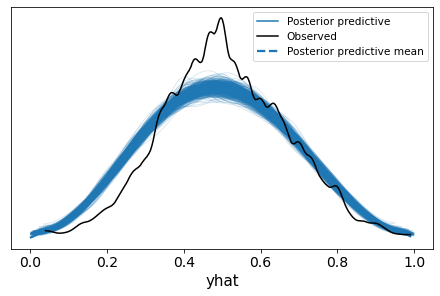

In [238]:
az.plot_ppc(numpyro_data, data_pairs={"yhat":"yhat"},num_pp_samples=500)

<AxesSubplot:xlabel='preds', ylabel='estimate'>

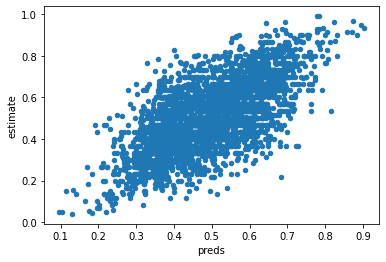

In [239]:
df_test["preds"] = numpyro_data.posterior_predictive.mean(dim=['chain', 'draw']).yhat

df_test.plot.scatter(x = "preds", y = "estimate")

In [240]:
df_test[["estimate","preds"]].corr()

,estimate,preds
estimate,1.000000,0.669402
preds,0.669402,1.000000


<AxesSubplot:xlabel='mean_pred', ylabel='mean_est'>

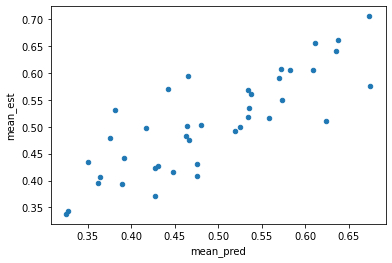

In [241]:
plot_df = df_test >> group_by(X.querytype, X.querydetail) >> summarize(mean_pred = np.mean(X.preds), mean_est = np.mean(X.estimate))
plot_df.plot.scatter(x="mean_pred", y="mean_est")

In [242]:
plot_df.corr()

,mean_pred,mean_est
mean_pred,1.000000,0.825798
mean_est,0.825798,1.000000


Below is an alternate version meant to estimate trial-level responses with inherent variability from the internal mental sampling process. It should be given different data

In [232]:
def bayesian_sampler2(data, y=None):

    n_Ps = len(np.unique(data["subj"]))
    n_conds = len(np.unique(data["cond"]))
    trial = data["trial"]
    subj = data["subj"]
    cond = data["cond"]
    
    not_conjdisj = abs(1-data["conjdisj_trial"])

    # population level parameters/priors
    sigma = numpyro.sample("sigma", dist.HalfCauchy(.02)) # response noise parameter
#     sigma = .025

    # need a beta, and N's per person
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
        N_deltas = numpyro.sample("N_delta", dist.HalfCauchy(10))
        N_primes = numpyro.sample("N_prime", dist.HalfCauchy(10))
        
        # need a theta per person-query
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    N = 1 + N_primes[subj] + N_deltas[subj] * not_conjdisj # they required N be at least 1, no pooling for now
    beta = betas[subj]
    theta_ind = ((subj*2)+cond)
    theta = thetas[theta_ind,:]
    
    numerator = jnp.sum(theta*data["X_num"], axis=-1)
    denom = jnp.sum(theta*data["X_denom"], axis=-1)
    pi_l = jnp.divide(numerator, denom)
    
    with numpyro.plate("data", len(trial)):
        pi = numpyro.sample("pi", dist.Beta(N*pi_l, N*(1-pi_l))) # continuous approx to binomial()
        p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
        yhat = numpyro.sample("yhat", dist.Normal(p_bs, sigma), obs=y)
        
    
    return yhat

In [231]:
from jax import random
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(bayesian_sampler2)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1_000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, X_data, y_data)

warmup:   4%|▍         | 79/2000 [00:44<17:52,  1.79it/s, 1023 steps of size 2.56e-02. acc. prob=0.76]


KeyboardInterrupt: 

In [214]:
# mcmc.print_summary()

rhats are insane, so that's bad